<a href="https://colab.research.google.com/github/mushe/Keras_to_Unity_Barracuda_experiments/blob/main/Keras_to_onnx_Unity_Barracuda_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KerasでMNIST分類を学習させてUnity Barracudaで使う (2021/5/30)

※Colabデフォルトのtensorflowだとonnxにコンバートできなかったのでバージョンを変えておく

In [ ]:
!pip3 uninstall tensorflow

In [ ]:
!pip3 install tensorflow==2.2.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


ここからコーディングスタート

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

MNISTのデータ（手書きの数字と0-9の正解ラベル）をダウンロード

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


MNISTのデータを正規化(0～255 to 0～1.0)

In [ ]:
x_train[0]

In [ ]:
x_train[0].astype('float32') / 255.0

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

入力データの次元をKeras対応の形に整える

In [ ]:
print(x_train.shape)
x_train = np.expand_dims(x_train, -1)
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
print(x_test.shape)
x_test = np.expand_dims(x_test, -1)
print(x_test.shape)

(10000, 28, 28)
(10000, 28, 28, 1)


正解データをOne hot encodingする

---

What is One Hot Encoding? Why and When Do You Have to Use it?

https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

---

例えば以下のようになる

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

モデルを記述する

てきとうに良さそうなネットワークを探して適用する

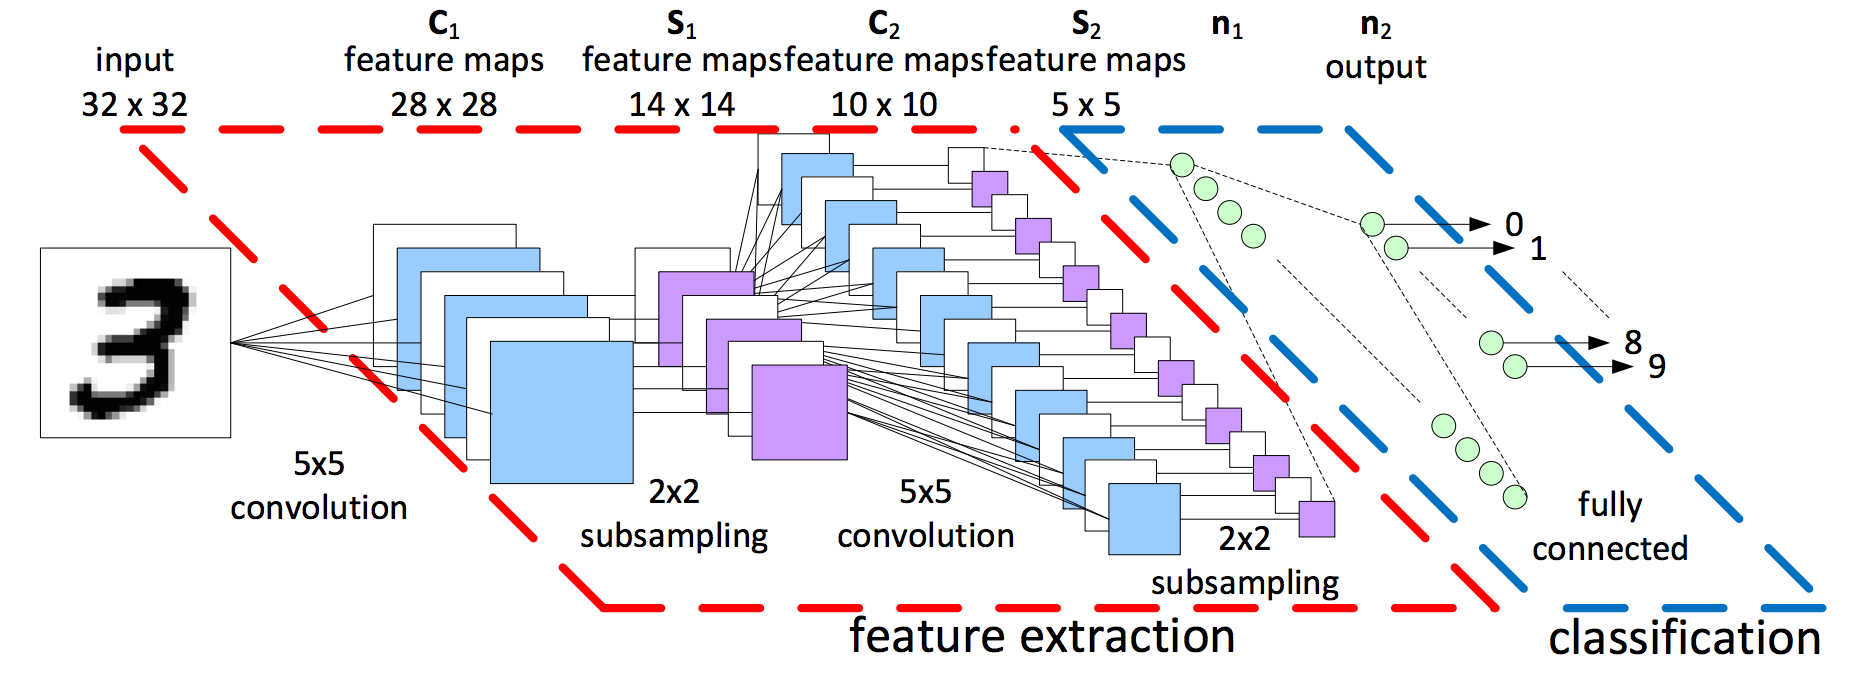

https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist より

convolution = 畳み込み

subsampling = プーリング

※この時、サポートされていないオペレーターを使うとコンバートできない

オペレーターリスト：https://docs.unity3d.com/Packages/com.unity.barracuda@2.0/manual/SupportedOperators.html

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Model

input = Input(shape=(28,28,1))
x = input

x = Conv2D(filters=5*8+8, kernel_size=5, activation='relu',input_shape=(28,28,1))(x)
x = MaxPool2D()(x)
x = Conv2D(filters=5*16+16, kernel_size=5, activation='relu')(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=10, activation='softmax')(x)

output = x

model = Model(input, output)

作成したモデルの概要を表示

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 48)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 96)          115296    
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570  

学習開始！

※注意※
ColabのランタイムをGPUにしていないと膨大な時間がかかる

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=80, epochs=20, validation_split=0.1)

Epoch 1/5
5400/5400 [==============================] - 213s 39ms/step - loss: 0.0775 - accuracy: 0.9769 - val_loss: 0.0442 - val_accuracy: 0.9888
Epoch 2/5
5400/5400 [==============================] - 198s 37ms/step - loss: 0.0392 - accuracy: 0.9883 - val_loss: 0.0430 - val_accuracy: 0.9888
Epoch 3/5
5400/5400 [==============================] - 196s 36ms/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0282 - val_accuracy: 0.9920
Epoch 4/5
5400/5400 [==============================] - 195s 36ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0377 - val_accuracy: 0.9917
Epoch 5/5
5400/5400 [==============================] - 201s 37ms/step - loss: 0.0158 - accuracy: 0.9957 - val_loss: 0.0433 - val_accuracy: 0.9917


完成！


※過学習をざっくり確認するには

accuracyとval_accuracyが大体同じように推移していれば大丈夫

accuracyだけが上がっていったり、val_accuracyが煮詰まっていたら過学習 → やりすぎ

なんか上手くいってるっぽいけど、実際に使ってみると全然駄目ということになる

## 出来上がったKerasのモデルをonnx形式でエクスポートする

https://github.com/onnx/keras-onnx

In [ ]:
model.save('model.h5') # 一応学習モデルのバックアップをとっておく

In [ ]:
pip install keras2onnx

In [ ]:
import keras2onnx
onnx_model = keras2onnx.convert_keras(model, model.name)
keras2onnx.save_model(onnx_model, 'mnist_from_keras.onnx')

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 23 -> 14


左のFilesに「mnist_from_keras.onnx」というファイルができていれば完了！

ダウンロードしてUnityで使う。